# Sentiment Analysis Using Tensorflow LSTM - CNN with Attention Layer

## Imports

In [19]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, Conv1D, MaxPooling1D, Embedding, Dropout,Dense, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adamax , Adam

from attention.layers import AttentionLayer
import tensorflow as tf
from tensorflow.python.client import device_lib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #This is for multiple print statements per cell

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/erolerten/anaconda3/envs/venv-tensorflow/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Confirm GPU processing available

In [20]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n\n',value) # MUST RETURN True IF IT CAN!!

print()
value = tf.config.list_physical_devices('GPU')
print(value)

print()
print(device_lib.list_local_devices())

***If TF can access GPU: ***

 True

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4835385663889638669
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13141809011418823778
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2259151236521145369
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1259942707
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1685354012665512084
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Getting data

In [21]:
df = pd.read_csv('consolidated_tweet_data-cleaned-stemmed-lemmatized.csv', sep='\t')
df

,sentiment,text
0,negative,oh no it fade away again
1,positive,bunnylak will kill me but i cant stop listen t...
2,negative,last day in cali partyin for the last time wit...
3,negative,is have a major soar throat
4,positive,my last day a 12 year old
...,...,...
1611536,negative,twisuz yeah and how did thi happen i wa updat ...
1611537,negative,smittygoali im sorri about your dog
1611538,negative,posipat im alreadi there i wish you were here
1611539,negative,is think in 12 hour ill be at the airport thi ...


In [22]:
# How much of Dataset to be used
frac = 0.25
# sample and shuffle the dataset according to the fraction choise in the line above
df = df.sample(frac=frac).reset_index(drop=True)
df

,sentiment,text
0,positive,wait for the gt5 richter earthquak were expect...
1,positive,lt fight the nwo everi day
2,negative,the sun like to play hide and seek in liverpool
3,negative,weather bad slept in perfect day for clean the...
4,positive,just woke up from a 3 hour nap what a lazi day...
...,...,...
402880,positive,therealsavannah haha me either
402881,positive,musicjunkie11 freakin fun graaab 13 hour i lef...
402882,negative,southwestair ye total of 4 hour on hold with a...
402883,negative,just come outta the saunakinda coldgonna go wa...


## Tokenization for training

In [23]:
vocabulary_size = 8000

In [24]:
tokenizer = Tokenizer(num_words=vocabulary_size, split=" ", oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'].values)

In [25]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  104,   11,    4,
           1,    1, 3346,  135,  863,  172],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1401,  855,    4,    1,  396,   29],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    4,  288,   36,    3,
         157, 1775,    8, 4248,   12, 3130],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  277,  125,  830,   12,
         642,   29,   11,  405,    4,  976, 3287,  

## Model, Training and Testing

### Creating the model

In [26]:
model = Sequential()
model.add(Embedding(vocabulary_size, 256, input_length=X.shape[1]))
# model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Conv1D(32,16,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,12,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128,9,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(AttentionLayer(name='attention'))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 39, 256)           2048000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 39, 512)           1052672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 512)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 39, 32)            262176    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 19, 64)            24640     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 64)            

### Training the model

In [28]:
y = pd.get_dummies(df['sentiment']).values
[print(df['sentiment'][i], y[i]) for i in range(0,5)]

positive [0 1]
positive [0 1]
negative [1 0]
negative [1 0]
positive [0 1]


[None, None, None, None, None]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
batch_size = 32
epochs = 15
import time
from datetime import datetime
datetime = str(datetime.now())
csv_logger = tf.keras.callbacks.CSVLogger('training'+datetime+'.log')
start = time.time()
print("started at:")
print(start)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[csv_logger])
end = time.time()
elapsed = end - start
print(elapsed/60," minutes")

started at:
1586202847.4425693
Train on 322308 samples
Epoch 1/15
322308/322308 - 450s - loss: 0.4539 - accuracy: 0.7867
Epoch 2/15
322308/322308 - 438s - loss: 0.4062 - accuracy: 0.8162
Epoch 3/15
322308/322308 - 439s - loss: 0.3779 - accuracy: 0.8315
Epoch 4/15
322308/322308 - 443s - loss: 0.3506 - accuracy: 0.8466
Epoch 5/15
322308/322308 - 445s - loss: 0.3191 - accuracy: 0.8634
Epoch 6/15
322308/322308 - 446s - loss: 0.2849 - accuracy: 0.8806
Epoch 7/15
322308/322308 - 449s - loss: 0.2510 - accuracy: 0.8972
Epoch 8/15
322308/322308 - 442s - loss: 0.2220 - accuracy: 0.9100
Epoch 9/15
322308/322308 - 438s - loss: 0.1989 - accuracy: 0.9203
Epoch 10/15
322308/322308 - 439s - loss: 0.1805 - accuracy: 0.9289
Epoch 11/15
322308/322308 - 443s - loss: 0.1662 - accuracy: 0.9351
Epoch 12/15
322308/322308 - 447s - loss: 0.1542 - accuracy: 0.9404
Epoch 13/15
322308/322308 - 448s - loss: 0.1449 - accuracy: 0.9438
Epoch 14/15
322308/322308 - 438s - loss: 0.1386 - accuracy: 0.9472
Epoch 15/15
3223

Plotting training history

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

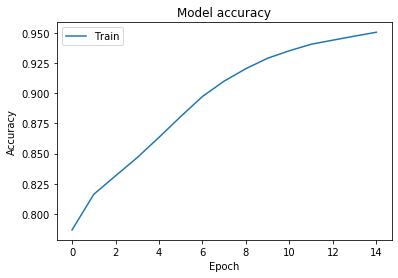

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

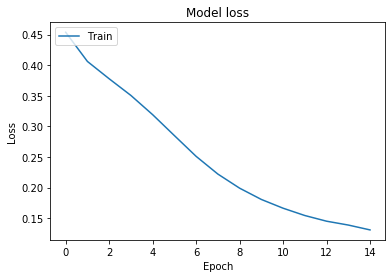

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Testing the model

In [32]:
predictions = model.predict(X_test)
[print(df['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

wait for the gt5 richter earthquak were expect soon  [0.00206166 0.9977099 ] [0 1]
lt fight the nwo everi day  [0.27681842 0.7201043 ] [1 0]
the sun like to play hide and seek in liverpool  [0.11073559 0.888525  ] [0 1]
weather bad slept in perfect day for clean the apart norway won the song contest havent seen it anybodi watch it  [0.69062245 0.3048151 ] [1 0]
just woke up from a 3 hour nap what a lazi day off to the inlaw for a turkey dinner  [8.7138015e-04 9.9910384e-01] [0 1]


[None, None, None, None, None]

In [33]:
accurate_prediction_count, inaccurate_prediction_count = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==np.argmax(y_test[i]):
        accurate_prediction_count += 1
    else:
        inaccurate_prediction_count += 1

total_predictions = accurate_prediction_count + inaccurate_prediction_count
print('Number of predictions: ', total_predictions)
print('Number of accurate predictions: ', accurate_prediction_count)
print('Number of false predictions: ', inaccurate_prediction_count)    
print('Accuracy: ', accurate_prediction_count/total_predictions)

Number of predictions:  80577
Number of accurate predictions:  63641
Number of false predictions:  16936
Accuracy:  0.7898159524430048


### Saving the trained model

name of the file

In [34]:
name = 'sentiment-analysis-trained-model'

In [35]:
from datetime import datetime
dateTimeObj = datetime.now()
date = str(dateTimeObj.date())
time = str(dateTimeObj.time())
timestamp = date+time
punctuation = ['-',':','.']
for sign in punctuation:
    timestamp = timestamp.replace(sign,'')
print(timestamp)

20200407004527923030


In [36]:
model.save(name+timestamp+'.h5')